In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import scanpy as sc
from scipy.sparse import csr_matrix
import scvi
import torch
import seaborn as sns

# Load data

In [3]:
filename = '../data_out/matrix_filtered_stim.h5ad'
adata = sc.read(filename)

In [4]:
adata

AnnData object with n_obs × n_vars = 29836 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well'
    var: 'gene_ids', 'feature_types'

In [5]:
# Mas eficiente para entrenar
adata.X = csr_matrix(adata.X)

# Doublet removal
(two or more cells are mistakenly captured together and sequenced as if they were a single cell)

In [6]:
# Only keep genes with more than 10 cells
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 29836 × 19673
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well'
    var: 'gene_ids', 'feature_types', 'n_cells'

**Highly variable genes** are crucial in scRNA-seq because they capture the key biological **differences between** cells, making it easier to identify and distinguish different cell types, states, and pathways. By focusing on these genes, researchers can filter out noise, improve clustering, and gain more meaningful insights into cellular heterogeneity and function.

In [7]:
# Keep top highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
adata

AnnData object with n_obs × n_vars = 29836 × 2000
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

### Train a model to find doublets

In [8]:
# %% First dimensionality reduction
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 19
scvi.settings.batch_size = 512
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.to_device('cuda')
vae.train(batch_size=512)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=268` reached.


In [9]:
# The reduced dimensionality model outputs are used as imputs to a classifier
# https://docs.scvi-tools.org/en/stable/user_guide/models/solo.html
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train(batch_size=512)

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.196. Signaling Trainer to stop.


In [14]:
df = solo.predict(
    return_logits=True
)
df['prediction'] = solo.predict(soft=False)
df['dif'] = df.doublet - df.singlet
df

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction,dif
AAACCCAAGGGCGAAG-5,-0.461095,0.463866,singlet,-0.924962
AAACCCACACAAATAG-5,0.467747,-0.304984,doublet,0.772731
AAACCCAGTAAGACCG-5,-1.247252,0.742939,singlet,-1.990191
AAACCCAGTCGTCGGT-5,0.472239,-0.164287,doublet,0.636526
AAACCCAGTGTTGACT-5,0.731941,0.176124,doublet,0.555817
...,...,...,...,...
TTTGTTGCACAGCCAC-8,-0.930781,0.954358,singlet,-1.885139
TTTGTTGCACTATGTG-8,-1.846843,2.339331,singlet,-4.186174
TTTGTTGCACTCAGAT-8,-0.906429,1.843249,singlet,-2.749678
TTTGTTGCAGTCAGTT-8,-1.936330,2.067906,singlet,-4.004236


In [15]:
print((df['prediction'] == 'singlet').sum()/len(df))
df.value_counts('prediction')
# 0.8597384899905909

0.8807480895562407


prediction
singlet    26278
doublet     3558
Name: count, dtype: int64

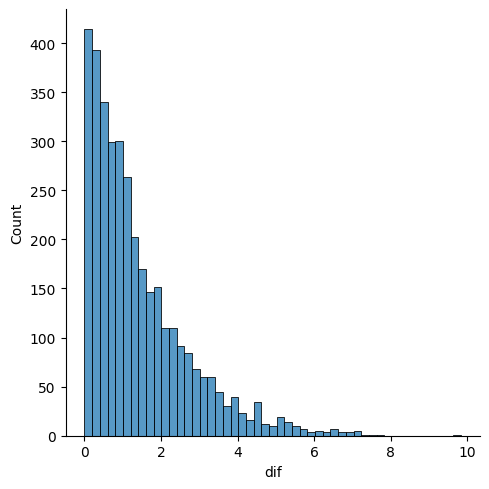

In [16]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

<Axes: >

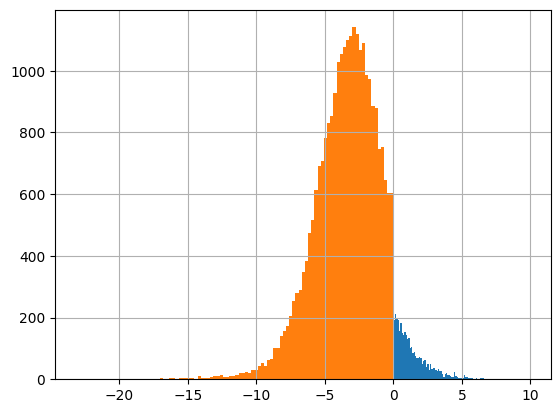

In [17]:
bins = 100
df[df['prediction']=='doublet']['dif'].hist(bins=bins)
df[df['prediction']=='singlet']['dif'].hist(bins=bins)

In [18]:
doublets = df[
    (df.prediction == 'doublet') &
    (df.dif > 1)
]
print(1 - len(doublets)/len(df))

0.939100415605309


In [19]:
doublets.to_csv(filename.replace('.h5ad', '_dublets.csv'))
doublets

,doublet,singlet,prediction,dif
AACAAAGCAGCGGATA-5,1.173051,-0.920094,doublet,2.093145
AACAACCCAGACCATT-5,1.335898,-1.016322,doublet,2.352220
AACAACCCAGGCCTGT-5,0.527935,-0.668215,doublet,1.196150
AACAACCGTCTGCATA-5,0.457640,-0.993685,doublet,1.451325
AACCACATCCTCTAGC-5,0.904774,-1.082534,doublet,1.987308
...,...,...,...,...
TTGGGATGTTGATGTC-8,0.804928,-0.614940,doublet,1.419868
TTGGGCGAGCCACAAG-8,0.809698,-0.876049,doublet,1.685747
TTGTTCAGTTGATGTC-8,1.899681,-1.707164,doublet,3.606845
TTTACCACAGCCATTA-8,0.862832,-0.296975,doublet,1.159807


In [20]:
# Add dublets to obs
adata = sc.read(
    filename,
    cache=True,
    gex_only=False,
    # make_unique=True
)
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata

AnnData object with n_obs × n_vars = 29836 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet'
    var: 'gene_ids', 'feature_types'

In [21]:
# Aca obtenemos un número mas parecido al paper en cuanto a celulas
adata = adata[~adata.obs['doublet']]
adata

View of AnnData object with n_obs × n_vars = 28019 × 36601
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet'
    var: 'gene_ids', 'feature_types'

# Preprocessing

In [22]:
# Mitocondrial, 13
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var.value_counts('mt')

/tmp/ipykernel_1481770/558155064.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


mt
False    36588
True        13
Name: count, dtype: int64

In [23]:
# Ribosomal Genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes


,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [24]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var.value_counts('ribo')

ribo
False    36514
True        87
Name: count, dtype: int64

In [25]:
adata.var

,gene_ids,feature_types,mt,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False
FAM138A,ENSG00000237613,Gene Expression,False,False
OR4F5,ENSG00000186092,Gene Expression,False,False
AL627309.1,ENSG00000238009,Gene Expression,False,False
AL627309.3,ENSG00000239945,Gene Expression,False,False
...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,False,False
AC023491.2,ENSG00000278633,Gene Expression,False,False
AC007325.1,ENSG00000276017,Gene Expression,False,False
AC007325.4,ENSG00000278817,Gene Expression,False,False


In [26]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [27]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL157829.1,ENSG00000285820,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL445644.1,ENSG00000233516,Gene Expression,False,False,0,0.000000,100.000000,0.0
TLR4,ENSG00000136869,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL354754.1,ENSG00000231901,Gene Expression,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
MT-CO3,ENSG00000198938,Gene Expression,True,False,27979,118.427315,0.142760,3318215.0
MT-ATP6,ENSG00000198899,Gene Expression,True,False,27979,91.888824,0.142760,2574633.0
MT-ND4,ENSG00000198886,Gene Expression,True,False,27983,66.059601,0.128484,1850924.0
MT-CO1,ENSG00000198804,Gene Expression,True,False,27987,92.797424,0.114208,2600091.0


In [28]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AC037459.3,ENSG00000254230,Gene Expression,False,False,3,0.000107,99.989293,3.0,3
AC009505.1,ENSG00000234162,Gene Expression,False,False,3,0.000107,99.989293,3.0,3
AC005014.3,ENSG00000272537,Gene Expression,False,False,3,0.000107,99.989293,3.0,3
ASIP,ENSG00000101440,Gene Expression,False,False,3,0.000107,99.989293,3.0,3
AC108051.1,ENSG00000227680,Gene Expression,False,False,3,0.000107,99.989293,3.0,3
...,...,...,...,...,...,...,...,...,...
MT-CO3,ENSG00000198938,Gene Expression,True,False,27979,118.427315,0.142760,3318215.0,27979
MT-ATP6,ENSG00000198899,Gene Expression,True,False,27979,91.888824,0.142760,2574633.0,27979
MT-ND4,ENSG00000198886,Gene Expression,True,False,27983,66.059601,0.128484,1850924.0,27983
MT-CO1,ENSG00000198804,Gene Expression,True,False,27987,92.797424,0.114208,2600091.0,27987


In [29]:
adata.obs.sort_values('n_genes_by_counts')

,condition,crispr,guide_id,gene,well,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTCCATCATGGCACC-8,Stim,perturbed,TAGAP-1,TAGAP,8,False,181,849.0,660.0,77.738518,20.0,2.355713
TCGGGACTCAGGAAAT-7,Stim,perturbed,IFNG-1,IFNG,7,False,188,880.0,691.0,78.522728,21.0,2.386364
GACCGTGTCCACGAAT-8,Stim,perturbed,CD2-1,CD2,8,False,188,1384.0,1194.0,86.271675,37.0,2.673410
GTTAGACCAATCCAGT-5,Stim,perturbed,IFNG-1,IFNG,5,False,192,744.0,546.0,73.387100,32.0,4.301075
AGACTCAGTGCGTTTA-8,Stim,perturbed,FOXL2NB-2,FOXL2NB,8,False,199,955.0,740.0,77.486908,25.0,2.617801
...,...,...,...,...,...,...,...,...,...,...,...,...
TGACGCGGTACCTGTA-8,Stim,perturbed,IL9R-1,IL9R,8,False,5918,27879.0,2026.0,7.267119,3650.0,13.092291
TAGGTTGCACGCACCA-6,Stim,perturbed,CEACAM1-1,CEACAM1,6,False,5918,31313.0,2103.0,6.716061,4568.0,14.588191
GACAGCCAGGCTCACC-6,Stim,perturbed,IKZF3-1,IKZF3,6,False,6073,31858.0,2010.0,6.309247,4592.0,14.413961
AGACCATGTACACGCC-5,Stim,perturbed,IL1R1-2,IL1R1,5,False,6082,33447.0,2800.0,8.371453,5120.0,15.307800


In [30]:
sc.pp.filter_cells(adata, min_genes=200)
adata.obs.sort_values('n_genes_by_counts')

,condition,crispr,guide_id,gene,well,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
AACAAGATCGGTCACG-8,Stim,perturbed,BICDL2-1,BICDL2,8,False,201,724.0,509.0,70.303871,19.0,2.624310,201
GCAGCCAGTCGAAACG-7,Stim,perturbed,TAGAP-1,TAGAP,7,False,215,785.0,567.0,72.229301,17.0,2.165605,215
ATTCCATCATACTGTG-5,Stim,perturbed,TNFRSF1A-1,TNFRSF1A,5,False,226,781.0,543.0,69.526253,35.0,4.481434,226
ATCACTTCACCCAAGC-8,Stim,perturbed,CD247-2,CD247,8,False,227,1020.0,786.0,77.058823,26.0,2.549020,227
GTGGAGATCCTCACGT-6,Stim,perturbed,MGST3-1,MGST3,6,False,232,1158.0,891.0,76.943001,37.0,3.195164,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACGCGGTACCTGTA-8,Stim,perturbed,IL9R-1,IL9R,8,False,5918,27879.0,2026.0,7.267119,3650.0,13.092291,5918
TAGGTTGCACGCACCA-6,Stim,perturbed,CEACAM1-1,CEACAM1,6,False,5918,31313.0,2103.0,6.716061,4568.0,14.588191,5918
GACAGCCAGGCTCACC-6,Stim,perturbed,IKZF3-1,IKZF3,6,False,6073,31858.0,2010.0,6.309247,4592.0,14.413961,6073
AGACCATGTACACGCC-5,Stim,perturbed,IL1R1-2,IL1R1,5,False,6082,33447.0,2800.0,8.371453,5120.0,15.307800,6081


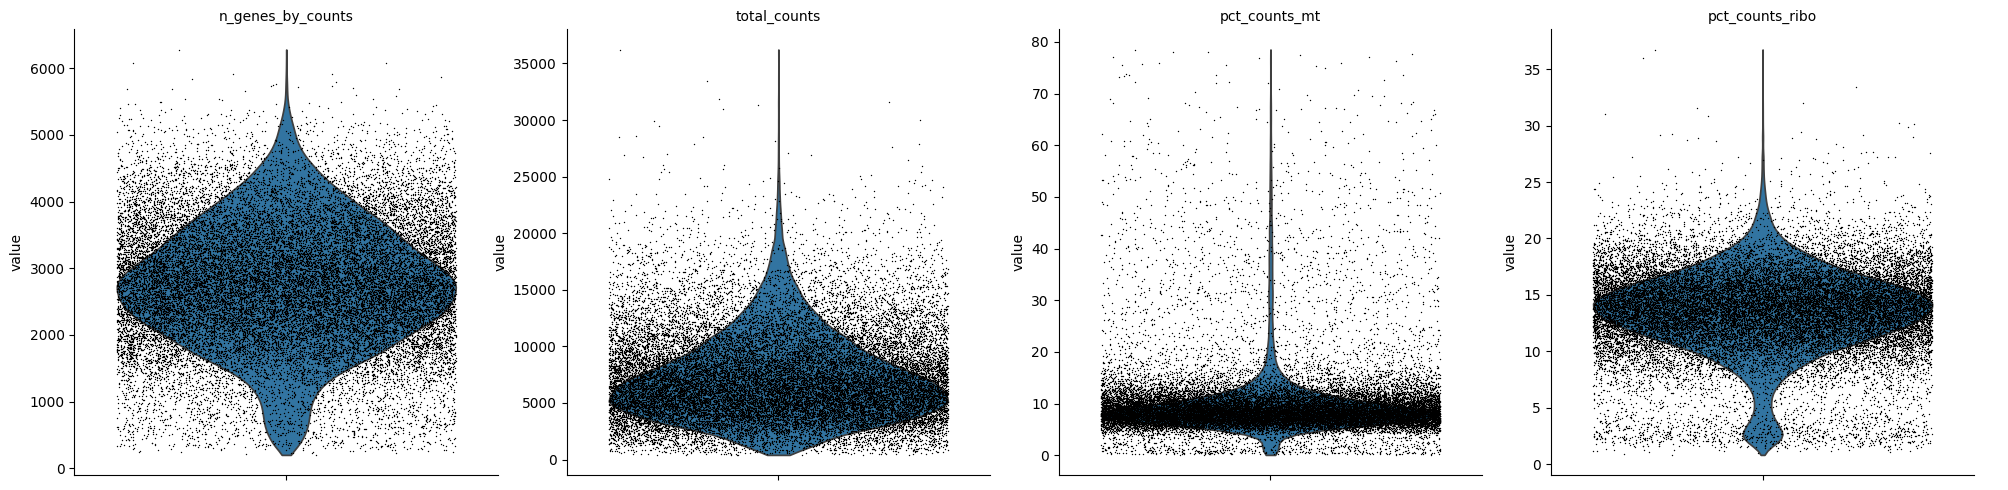

In [31]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [32]:
import numpy as np
upper_lim_n_genes_by_counts = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim_total_counts = np.quantile(adata.obs.total_counts.values, .98)
upper_lim_pct_counts_mt = np.quantile(adata.obs.pct_counts_mt.values, .98)
upper_lim_pct_counts_ribo = np.quantile(adata.obs.pct_counts_ribo.values, .98)
upper_lim_n_genes_by_counts, upper_lim_total_counts, upper_lim_pct_counts_mt, upper_lim_pct_counts_ribo


(4635.0, 17301.839999999967, 39.29346961975089, 20.66908008575438)

In [33]:
adata = adata[adata.obs.n_genes_by_counts < 5000]
adata

View of AnnData object with n_obs × n_vars = 27811 × 22501
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [34]:
adata = adata[adata.obs.pct_counts_mt < 25]
adata

View of AnnData object with n_obs × n_vars = 26625 × 22501
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [35]:
adata = adata[(adata.obs.pct_counts_ribo > 6) & (adata.obs.pct_counts_ribo < 25)]
adata

View of AnnData object with n_obs × n_vars = 26251 × 22501
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

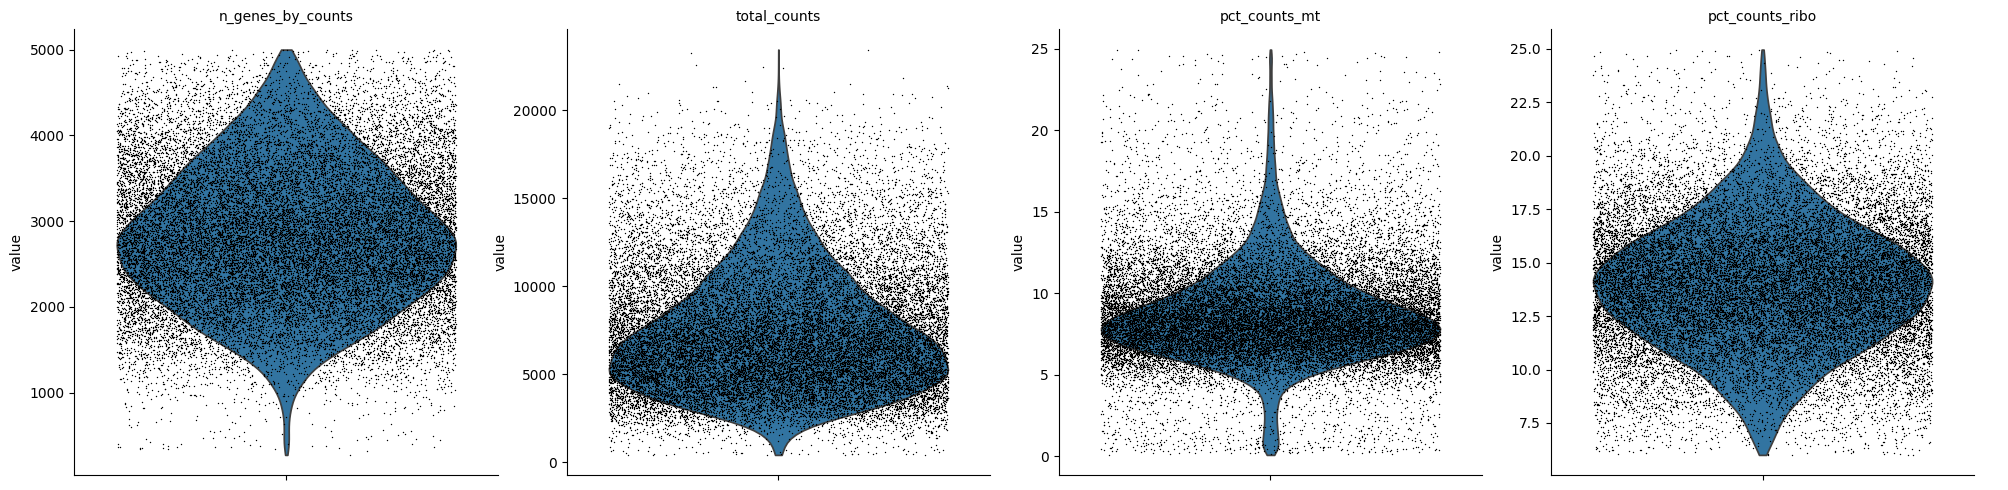

In [36]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [37]:
filename.replace('.h5ad', '_after_filtering.h5ad')
sc.write(filename.replace('.h5ad', '_after_filtering.h5ad'), adata)

# Normalization

In [40]:
adata.X.sum(axis = 1).max(), adata.X.sum(axis = 1).mean(), adata.X.sum(axis = 1).std(), adata.X.sum(axis = 1).min()

(23442.0, 7438.3184, 3522.2385, 415.0)

In [41]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [42]:
adata.X.sum(axis = 1)

matrix([[ 9999.906],
        [10000.137],
        [ 9999.787],
        ...,
        [ 9999.99 ],
        [ 9999.921],
        [10000.04 ]], dtype=float32)

In [43]:
sc.pp.log1p(adata) #change to log counts
adata.X.sum(axis = 1)

matrix([[2507.235 ],
        [3589.943 ],
        [3274.905 ],
        ...,
        [3017.4556],
        [2538.8906],
        [3151.4219]], dtype=float32)

In [44]:
adata.raw = adata

In [45]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 73860594 stored elements and shape (26251, 22501)>

In [46]:
adata

AnnData object with n_obs × n_vars = 26251 × 22501
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

# Clustering

In [47]:
# Esto no corta sino que agrega un flag
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [48]:
adata.var

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,False,False,36,0.001285,99.871516,36.0,36,False,0.001858,0.506567,-0.433861
AL627309.3,ENSG00000239945,Gene Expression,False,False,11,0.000393,99.960741,11.0,11,False,0.000507,0.475524,-0.529580
AL627309.5,ENSG00000241860,Gene Expression,False,False,304,0.011242,98.915022,315.0,304,False,0.015776,0.635227,-0.037142
AL627309.4,ENSG00000241599,Gene Expression,False,False,7,0.000250,99.975017,7.0,7,False,0.000343,0.628536,-0.057773
AL669831.2,ENSG00000229905,Gene Expression,False,False,5,0.000178,99.982155,5.0,5,False,0.000208,0.168690,-1.475696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,False,False,406,0.014776,98.550983,414.0,406,False,0.022155,0.652631,0.016524
AL592183.1,ENSG00000273748,Gene Expression,False,False,168,0.005996,99.400407,168.0,168,False,0.009011,0.557384,-0.277166
AC240274.1,ENSG00000271254,Gene Expression,False,False,157,0.006460,99.439666,181.0,157,False,0.009607,0.773862,0.390338
AC004556.3,ENSG00000276345,Gene Expression,False,False,5174,0.213998,81.533959,5996.0,5174,False,0.255732,0.513640,-0.593095


In [49]:
adata

AnnData object with n_obs × n_vars = 26251 × 22501
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

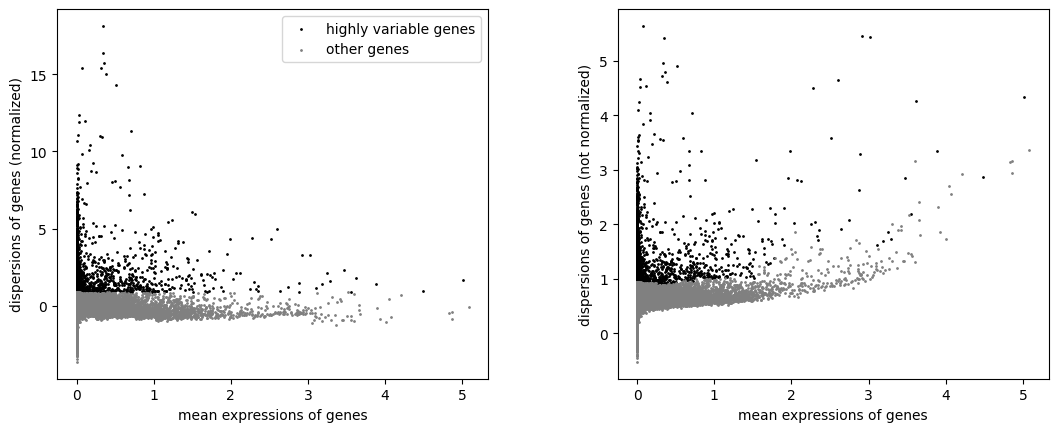

In [50]:
sc.pl.highly_variable_genes(adata)

In [51]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 26251 × 2000
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [52]:
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.regress_out.html
# Linear Regression
# Creo que tiene que ver con 'pct_counts_mt', 'pct_counts_ribo' que se pueden usar como referencia
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [53]:
sc.pp.scale(adata, max_value=10)

In [54]:
sc.tl.pca(adata, svd_solver='arpack')

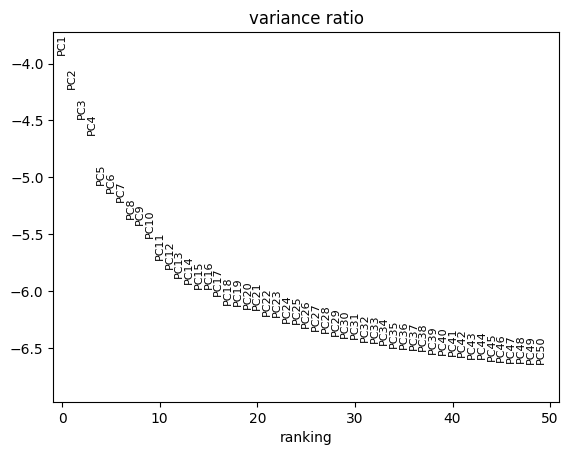

In [55]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [56]:
sc.pp.neighbors(adata, n_pcs = 30)

In [57]:
display(adata.obsp['distances'])
display(adata.obsp['connectivities'])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 420016 stored elements and shape (26251, 26251)>

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 600926 stored elements and shape (26251, 26251)>

In [58]:
sc.tl.umap(adata)

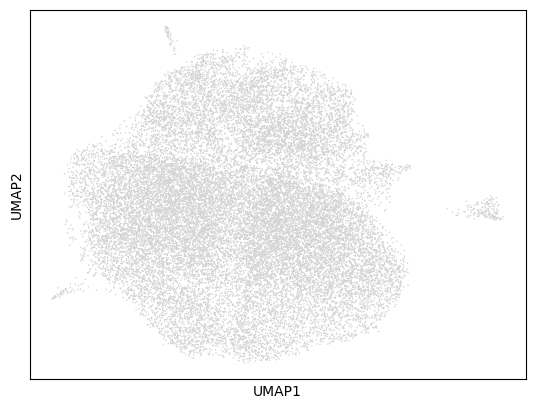

In [59]:
sc.pl.umap(adata)

In [60]:
sc.tl.leiden(adata, resolution = 0.5)

/tmp/ipykernel_1481770/3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [61]:
adata.obs

,condition,crispr,guide_id,gene,well,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
AAACCCAAGGGCGAAG-5,Stim,perturbed,CEACAM1-1,CEACAM1,5,False,1506,3263.0,723.0,22.157522,361.0,11.063438,1506,5
AAACCCACACAAATAG-5,Stim,perturbed,DEF6-1,DEF6,5,False,2980,6823.0,807.0,11.827641,743.0,10.889638,2980,0
AAACCCAGTAAGACCG-5,Stim,perturbed,LCP2-2,LCP2,5,False,2611,7027.0,373.0,5.308097,1097.0,15.611214,2611,0
AAACCCAGTCGTCGGT-5,Stim,perturbed,DEF6-1,DEF6,5,False,3025,6902.0,1003.0,14.532020,648.0,9.388583,3025,1
AAACCCAGTGTTGACT-5,Stim,perturbed,FOXD2-2,FOXD2,5,False,3613,10561.0,2070.0,19.600416,1024.0,9.696052,3613,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGTATTGA-8,Stim,perturbed,PIK3AP1-1,PIK3AP1,8,False,2123,4672.0,455.0,9.738870,660.0,14.126712,2123,0
TTTGTTGCACAGCCAC-8,Stim,perturbed,TNFRSF12A-2,TNFRSF12A,8,False,3755,11612.0,676.0,5.821564,1737.0,14.958663,3755,1
TTTGTTGCACTATGTG-8,Stim,perturbed,LHX6-2,LHX6,8,False,2040,4278.0,545.0,12.739597,595.0,13.908368,2040,1
TTTGTTGCAGTCAGTT-8,Stim,perturbed,TRIM21-2,TRIM21,8,False,1445,2824.0,534.0,18.909349,280.0,9.915014,1445,1


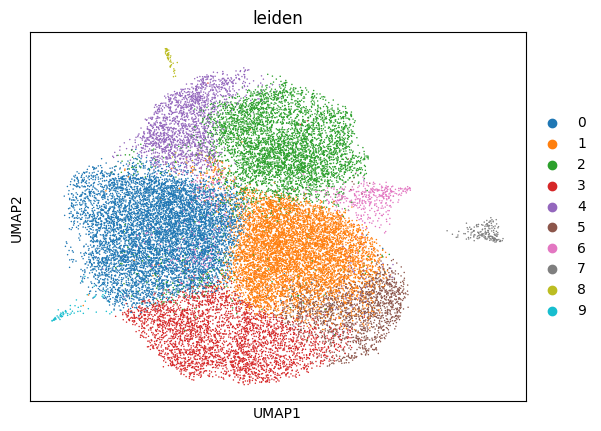

In [62]:
sc.pl.umap(adata, color=['leiden'])